# Investigating adjusted p-values from 625ppm vs 1500ppm eQTL analysis

__Author:__ Bryan Quach  
__Date:__ April 28, 2017

### Estimated Analysis Time: <1 days

## Objective

There are multiple objectives of this analysis. The main goal is to apply multiple testing correction to the initial results of the eQTL analyses (unadjusted p-values). Following the multiple testing correction, we will address the following questions:

* What is the q-value distribution of our results?
* How many gene-marker pairs produced a significant association?
* How many statistically significant eQTL-containing genes (eGenes) are observed?
* Which gene and marker comparisons produced the most significant hits?
* Which genes tested are eGenes?

## Software required

* [dplyr (R package)](https://cran.r-project.org/web/packages/dplyr/index.html)
* [qvalue (R package)](https://www.bioconductor.org/packages/release/bioc/html/qvalue.html)
* [GenomicRanges (R package)](https://bioconductor.org/packages/release/bioc/html/GenomicRanges.html)

## The Data

The data that we work with are results output from running a modified version of Daniel Oreper's eQTL analysis software. This software produces an R data file containing the environment in which the analysis was run, which includes a matrix of p-values with rows and columns corresponding to genes and markers respectively. In this analysis, we will look at results for the eQTL analyses in lung, liver, and kidney. The phenotype was the normalized expression differences between 1500ppm and 625ppm BD treated CC mice.

## Global multiple testing correction

We apply [FDR correction](https://en.wikipedia.org/wiki/False_discovery_rate) to the p-values from all association tests. The resulting q-values will be used for assessing significance of all gene-marker pairs at a specified threshold. To aid in data analysis, we will convert our matrices of p-values into a data frame with `NA` values removed.

In [1]:
library(dplyr)
library(qvalue)
library(GenomicRanges)

# Function for retrieving non-NA values from matrix
#
# Args:
#   haystack - matrix to search through
#
# Returns a dataframe of the p-values with gene and marker names listed
reshape.results <- function(haystack){
    hits <- which(!is.na(haystack), arr.ind=T)
    rnames <- rownames(haystack)[hits[,1]]
    cnames <- colnames(haystack)[hits[,2]]    
    pvals <- sapply(1:nrow(hits), function(i){haystack[hits[i,1], hits[i,2]]})
    results <- data.frame(gene=rnames, marker=cnames, pval=as.numeric(pvals))
    results <- results[order(results$gene),]
    return(results)
}

#Get p-value matrices for each tissue
tmp.env <- new.env()
load("data/625ppm_vs_1500ppm_lung.Rdata", envir=tmp.env)
matrix.lung <- get("out.mat", tmp.env)
load("data/625ppm_vs_1500ppm_liver.Rdata", envir=tmp.env)
matrix.liver <- get("out.mat", tmp.env)
load("data/625ppm_vs_1500ppm_kidney.Rdata", envir=tmp.env)
matrix.kidney <- get("out.mat", tmp.env)
rm(tmp.env)

#Reshape
pvals.lung <- reshape.results(matrix.lung)
pvals.liver <- reshape.results(matrix.liver)
pvals.kidney <- reshape.results(matrix.kidney)

#Apply FDR correction
qvals.lung <- qvalue(pvals.lung$pval, fdr.level=0.1) 
qvals.liver <- qvalue(pvals.liver$pval, fdr.level=0.1)
qvals.kidney <- qvalue(pvals.kidney$pval, fdr.level=0.1)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mg

## Identifying significant eGenes

For downstream analyses that focus only on the gene-level results, we will assign a representative p-value for each gene. A common approach to do this is to use the smallest p-value for a gene across tests as a test statistic. A permutation test is then applied where the gene expression values are permuted, and a p-value is derived from this permutation test procedure. Because this is computationally too expensive given our current resources, we will instead apply [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) to the p-values from each marker test with a gene. In this approach we tabulate the number of tests performed for each gene then multiply each p-value by that number. We will use the smallest Bonferroni corrected p-value as the representative p-value for a gene. We will then account for multiple comparisons across genes by appyling FDR correction.

In [2]:
#Apply Bonferroni correction
matrix.adj.lung <- matrix.lung * apply(matrix.lung,1,function(x){length(which(!is.na(x)))})
matrix.adj.liver <- matrix.liver * apply(matrix.liver,1,function(x){length(which(!is.na(x)))})
matrix.adj.kidney <- matrix.kidney * apply(matrix.kidney,1,function(x){length(which(!is.na(x)))})

#Apply value ceiling of 1 to p-values
matrix.adj.lung <- apply(matrix.adj.lung, 2, function(x){ifelse(x>1,1,x)})
matrix.adj.liver <- apply(matrix.adj.liver, 2, function(x){ifelse(x>1,1,x)})
matrix.adj.kidney <- apply(matrix.adj.kidney, 2, function(x){ifelse(x>1,1,x)})

#Assign representative p-value to each gene
gene.pval.lung <- apply(matrix.adj.lung, 1, min, na.rm=T)
if(length(which(gene.pval.lung==Inf))>0){ gene.pval.lung <- gene.pval.lung[-1*which(gene.pval.lung==Inf)] }
gene.pval.liver <- apply(matrix.adj.liver, 1, min, na.rm=T)
if(length(which(gene.pval.liver==Inf))>0){ gene.pval.liver <- gene.pval.liver[-1*which(gene.pval.liver==Inf)] }
gene.pval.kidney <- apply(matrix.adj.kidney, 1, min, na.rm=T)
if(length(which(gene.pval.kidney==Inf))>0){ gene.pval.kidney <- gene.pval.kidney[-1*which(gene.pval.kidney==Inf)] }

#Apply FDR correction
gene.qval.lung <- qvalue(p=gene.pval.lung, fdr.level=0.1)
gene.qval.liver <- qvalue(p=gene.pval.liver, fdr.level=0.1)
gene.qval.kidney <- qvalue(p=gene.pval.kidney, fdr.level=0.1)

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”

## Plotting statistics

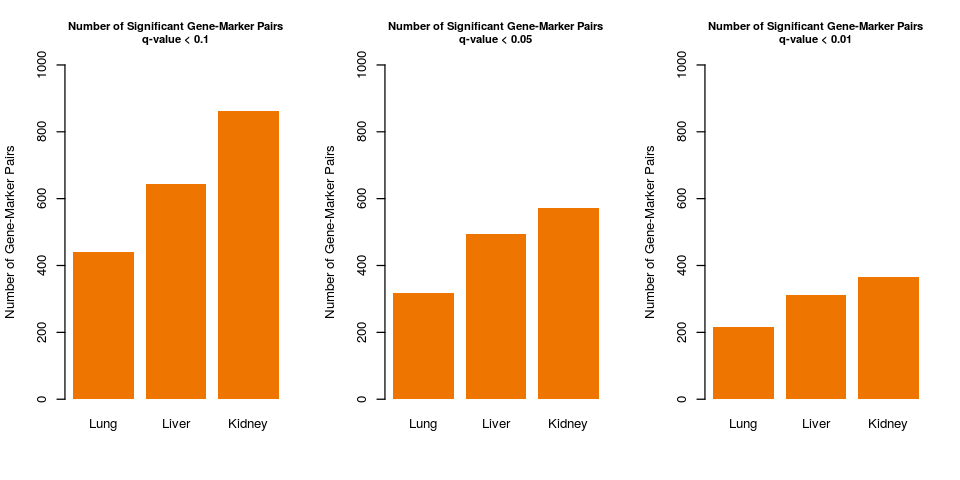

In [3]:
library(repr)

#P-value distributions
options(repr.plot.width=8, repr.plot.height=9)
par(mfrow=c(3,1))
hist(as.numeric(qvals.lung$qvalues), breaks=200, freq=T, ylim=c(0,3500), xlim=c(0,1),
     col="red", border="white",
     main="Lung q-values",
     ylab="Frequency",
     xlab="q-value")
hist(as.numeric(qvals.liver$qvalues), breaks=200, freq=T, ylim=c(0,3500), xlim=c(0,1),
     col="red", border="white",
     main="Liver q-values",
     ylab="Frequency", 
     xlab="q-value")
hist(as.numeric(qvals.kidney$qvalues), breaks=200, freq=T, ylim=c(0,3500), xlim=c(0,1),
     col="red", border="white",
     main="Kidney q-values",
     ylab="Frequency", 
     xlab="q-value")


#Calculate significant eGenes and gene marker pairs
for(cutoff in c(0.1,0.05,0.01)){
    num.egenes.lung <- length(which(gene.qval.lung$qvalues<cutoff))
    num.egenes.liver <- length(which(gene.qval.liver$qvalues<cutoff))
    num.egenes.kidney <- length(which(gene.qval.kidney$qvalues<cutoff))
    assign(x=paste0("num.egenes.",cutoff),value=c(num.egenes.lung, num.egenes.liver, num.egenes.kidney))

    num.sig.lung <- length(which(qvals.lung$qvalues<cutoff))
    num.sig.liver <- length(which(qvals.liver$qvalues<cutoff))
    num.sig.kidney <- length(which(qvals.kidney$qvalues<cutoff))
    assign(x=paste0("num.sig.",cutoff),value=c(num.sig.lung, num.sig.liver, num.sig.kidney))
}

#Significant eGenes
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,3))
barplot(height=num.egenes.0.1, beside=T, ylab="Number of Genes", ylim=c(0,200),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.1",
        cex.main=0.85)
barplot(height=num.egenes.0.05, beside=T, ylab="Number of Genes", ylim=c(0,200),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.05",
        cex.main=0.85)
barplot(height=num.egenes.0.01, beside=T, ylab="Number of Genes", ylim=c(0,200),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.01",
        cex.main=0.85)


#Significant gene marker paris
par(mfrow=c(1,3))
barplot(height=num.sig.0.1, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,1000),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.1",
        cex.main=0.85)
barplot(height=num.sig.0.05, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,1000),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.05",
        cex.main=0.85)
barplot(height=num.sig.0.01, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,1000),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.01",
        cex.main=0.85)

## Retrieving most significant associations

For each tissue, we retrieve the 100 gene-marker pairs that produced the most significant q-values and list them below. Notably, not all the records listed have q-values that would pass typical thresholds.

In [4]:
#Load marker coordinates and gene expression data
tmp.env <- new.env()
load("data/625ppm_vs_1500ppm_lung.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.lung <- tmp.data$exp.mat
marker.map <- tmp.data$marker.map
load("data/625ppm_vs_1500ppm_liver.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.liver <- tmp.data$exp.mat
load("data/625ppm_vs_1500ppm_kidney.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.kidney <- tmp.data$exp.mat
rm(tmp.env, tmp.data)

#Make data frame of sorted results and subset
lung.list <- cbind(pvals.lung, qval=qvals.lung$qvalues)
lung.list <- lung.list[order(lung.list$qval),]
liver.list <- cbind(pvals.liver, qval=qvals.liver$qvalues)
liver.list <- liver.list[order(liver.list$qval),]
kidney.list <- cbind(pvals.kidney, qval=qvals.kidney$qvalues)
kidney.list <- kidney.list[order(kidney.list$qval),]
top.lung.list <- lung.list[1:100,]
top.liver.list <- liver.list[1:100,]
top.kidney.list <- kidney.list[1:100,]

#Get genomic coordinates for top markers
get.location <- function(marker, marker.map){
    boundary.markers <- unlist(strsplit(x=marker, split=".", fixed=T))
    m.index1 <- which(marker.map$marker==boundary.markers[1])
    m.index2 <- which(marker.map$marker==boundary.markers[2])
    if(length(m.index1)!=1 | length(m.index2)!=1){
        error_msg <- paste0("Error: Marker not found in marker map: ", marker)
        stop(error_msg)
    }
    #Get marker region
    m1 <- marker.map[m.index1,]
    m2 <- marker.map[m.index2,]
    if(m1$chromosome!=m2$chromosome){stop("Error: Markers merged across chromosomes!")}
    m.region <- c(m1$chromosome, m1$position, m2$position)
    return(m.region)
}
top.lung.list <- cbind(top.lung.list, t(sapply(as.character(top.lung.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
top.liver.list <- cbind(top.liver.list, t(sapply(as.character(top.liver.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
top.kidney.list <- cbind(top.kidney.list, t(sapply(as.character(top.kidney.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
colnames(top.lung.list)[3:5] <- c("chr", "start", "end")
colnames(top.liver.list)[3:5] <- c("chr", "start", "end")
colnames(top.kidney.list)[3:5] <- c("chr", "start", "end")

#Get gene expression statistics
gene.calc <- function(gene, expression){
    abundance <- expression[,colnames(expression)==gene]
    return(c(mean(abundance), sd(abundance), range(abundance)))
}
gene.stats.lung <- t(sapply(top.lung.list$gene, gene.calc, expression=rna.levels.lung))
gene.stats.liver <- t(sapply(top.liver.list$gene, gene.calc, expression=rna.levels.liver))
gene.stats.kidney <- t(sapply(top.kidney.list$gene, gene.calc, expression=rna.levels.kidney))
top.lung.list <- cbind(top.lung.list, gene.stats.lung)
top.liver.list <- cbind(top.liver.list, gene.stats.liver)
top.kidney.list <- cbind(top.kidney.list, gene.stats.kidney)
colnames(top.lung.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.liver.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.kidney.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")

#Display tables
cat("Lung\n")
top.lung.list
cat("Liver\n")
top.liver.list
cat("Kidney\n")
top.kidney.list

#Write tables to file
write.table(x=top.lung.list, file="results/lung_top100_hits_adjusted_pvals_625_vs_1500.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")
write.table(x=top.liver.list, file="results/liver_top100_hits_adjusted_pvals_625_vs_1500.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")
write.table(x=top.kidney.list, file="results/kidney_top100_hits_adjusted_pvals_625_vs_1500.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")


Lung


gene          marker                         chr   start     end      
14228 Ttc22         UNC7905375.UNC040215368        chr4  105050114 105593993
14250 Ttc22         UNC7913411.UNC7928876          chr4  105636559 106692080
14275 Ttc22         JAX00122955.UNC7931463         chr4  106754201 106907260
14300 Ttc22         JAX00561354.JAX00561354        chr4  106991042 106991042
14337 Ttc22         UNC7932936.UNC7947729          chr4  107007905 108092055
13409 Glipr2        UNC041043835.JAX00549124       chr4  42893122  43420015 
13458 Glipr2        UNC7134471.UNC7149801          chr4  43435464  44471396 
13504 Glipr2        UNC7150041.UNC040499102        chr4  44482964  45420044 
60138 Stfa1         UNC26653811.UNC26655798        chr16 36841001  37082528 
60155 Fbxo40        UNC160204180.UNC26667086       chr16 37102047  38320325 
60121 Fbxo40        UNC26653811.UNC26655798        chr16 36841001  37082528 
62843 Fkbp5         JAX00435265.UNC27752624        chr17 29253980  30011091 
14120 Hook1         UNC7778493.UNC7800092          chr4  95319709  97179525 
60133 Ndufb4        UNC26653811.UNC26655798        chr16 36841001  37082528 
4925  Obp2a         UNC2746803.UNC2747334          chr2  24531371  24562440 
9632  Impa1         UNC4696231.UNC4770292          chr3  10317964  15905320 
50522 Serpina4-ps1  UNC21786436.UNC21786664        chr12 105226225 105246146
50977 Tnfaip2       UNC21878039.UNC21894866        chr12 111432878 112700981
51030 Tnfaip2       UNC21894871.UNC21910865        chr12 112701505 113755394
77    Eya1          UNC130265.UNC134669            chr1  13154530  13530989 
62907 Ubash3a       UNC27753023.UNC27767093        chr17 30047121  31280270 
60212 Nr1i2         UNC26676167.UNC26684229        chr16 39131892  39939064 
60197 Nr1i2         UNC26667543.UNC26676137        chr16 38372487  39130041 
60127 Hcls1         UNC26653811.UNC26655798        chr16 36841001  37082528 
60162 Hcls1         UNC160204180.UNC26667086       chr16 37102047  38320325 
60169 Ndufb4        UNC160204180.UNC26667086       chr16 37102047  38320325 
60196 Ndufb4        UNC26667543.UNC26676137        chr16 38372487  39130041 
14326 Nrd1          UNC7932936.UNC7947729          chr4  107007905 108092055
50519 Serpina3k     UNC21786436.UNC21786664        chr12 105226225 105246146
9580  Pkia          UNC4648546.UNC4678067          chr3  7026024   9051488  
⋮     ⋮             ⋮                              ⋮     ⋮         ⋮        
64358 Ppp4r1        UNC28210337.UNC28211157        chr17 66729357  66769891 
56869 Psca          UNC25896223.UNC25904367        chr15 74595504  75277140 
49056 Gen1          JAX00325494.UNC20623452        chr12 11090189  11091797 
12896 1110037F02Rik backupUNC040475692.JAX00545248 chr4  9211387   11800451 
12917 1110037F02Rik UNC6742980.UNC040602308        chr4  11832099  13746588 
50520 Serpina3m     UNC21786436.UNC21786664        chr12 105226225 105246146
14187 Slc35d1       UNC7859499.UNC7873155          chr4  101742674 102686507
67379 Mir6988       JAX00469668.UNC29855954        chr19 6571054   6902721  
67458 Mir6988       UNC29856661.UNC29864970        chr19 6982911   7933354  
14200 Slc35d1       UNC7873851.UNC7888795          chr4  102753749 103864654
26326 Igsf23        UNC12479791.UNC12510962        chr7  19803981  25886271 
26241 Igsf23        UNC12476157.UNC12479182        chr7  19473458  19759911 
9693  Hltf          JAX00516260.UNC4839666         chr3  19882436  21149664 
9667  Hltf          JAX00104869.UNC4813610         chr3  18279377  19409623 
9680  Hltf          UNC4814654.UNC4820379          chr3  19467863  19860171 
5365  Sec16a        UNC2769757.JAX00092398         chr2  26408983  26731528 
41479 Myf6          UNC18577118.UNC18653313        chr10 101542550 106368372
41484 Myf6          UNC18654283.JAX00298238        chr10 106427940 106912976
41488 Myf6          UNC100187548.JAX00298355       chr10 106920844 107646482
58450 Arf3          UNC26210905.UNC26211240        chr15 99470609  99513852 
41

Liver


gene          marker                   chr   start     end      
29807 E2f7          UNC18700285.UNC18708909  chr10 109484027 110033340
15490 Cyp3a59       UNC050433302.UNC10384598 chr5  145958559 147485695
15516 Cyp3a59       UNC10384922.UNC10385552  chr5  147505087 147535570
15577 Flt1          JAX00600891.UNC10401202  chr5  148442078 148543242
15531 Flt1          UNC10385644.UNC10395146  chr5  147542116 148105914
15554 Flt1          UNC10397110.JAX00136998  chr5  148245747 148314277
15565 Flt1          UNC10397739.JAX00600890  chr5  148324065 148441915
15626 Flt1          UNC10406187.UNC050249355 chr5  148817491 148835635
15638 Flt1          UNC10406637.UNC10414582  chr5  148841878 149187563
3430  Obp2a         UNC2746803.UNC2747334    chr2  24531371  24562440 
9227  3110043O21Rik UNC7054545.UNC7060540    chr4  35777302  36390021 
45107 Cdkn1a        UNC27753023.UNC27767093  chr17 30047121  31280270 
15463 Cyp3a59       UNC10365932.UNC10371047  chr5  145519553 145915359
15543 Flt1          UNC10395292.UNC10397004  chr5  148123975 148235274
15677 Flt1          UNC10419602.UNC10428605  chr5  149471600 150017329
30154 Ctdsp2        UNC18954707.UNC18961845  chr10 126429359 127050365
30108 Ctdsp2        UNC18954024.UNC18954348  chr10 126377348 126398272
15614 Flt1          UNC10404645.UNC10405837  chr5  148750496 148801107
42944 Bcl6          UNC26482789.UNC26489040  chr16 23843394  24373994 
42961 Bcl6          UNC26489252.UNC26489252  chr16 24385932  24385932 
42966 Bcl6          UNC26489493.UNC26508271  chr16 24401914  25788210 
42925 Bcl6          UNC26482218.UNC26482549  chr16 23806314  23827673 
42906 Bcl6          UNC26481882.UNC26481882  chr16 23790608  23790608 
37428 Nfil3         UNC22598191.UNC22613247  chr13 52306795  53193329 
29189 Gstt3         UNC18245269.UNC18248787  chr10 74622152  74972054 
932   Snora75       UNC1067986.JAX00006232   chr1  84177354  88526554 
959   Snora75       JAX00258020.UNC1103435   chr1  88609381  90627755 
29166 Gstt3         UNC18201974.UNC18243811  chr10 70820186  74518605 
19444 Cox7a1        UNC12572462.UNC12573732  chr7  31229864  31312408 
15017 Rhbdd2        UNC10247043.UNC10251963  chr5  136258327 136611946
⋮     ⋮             ⋮                        ⋮     ⋮         ⋮        
48533 Pla2g16       UNC29865458.UNC29866758  chr19 8084450   8426861  
48573 Pla2g16       JAX00469933.JAX00469941  chr19 8521178   8549612  
48612 Pla2g16       JAX00469943.JAX00469945  chr19 8550563   8553472  
48650 Pla2g16       UNC29867469.UNC29867469  chr19 8600467   8600467  
2621  Dusp10        UNC2340030.JAX00278797   chr1  185374732 185387984
2613  Dusp10        UNC2337975.UNC010411487  chr1  184821004 185374397
37006 Hist1h1e      UNC22263703.UNC22267580  chr13 23772752  24032419 
36938 Hist1h1e      UNC22234794.UNC22263112  chr13 20735950  23717824 
29123 4930545H06Rik UNC18153616.JAX00291896  chr10 67576512  68587972 
40861 Ly6g          UNC25888851.UNC25895704  chr15 74042551  74542039 
27151 9430037G07Rik UNC16814383.UNC16822579  chr9  86986049  87617798 
27168 9430037G07Rik UNC090178541.UNC16883357 chr9  87629887  92994387 
15002 Hip1          UNC10247043.UNC10251963  chr5  136258327 136611946
15545 Lnx2          UNC10395292.UNC10397004  chr5  148123975 148235274
48375 Slc22a26      JAX00469668.UNC29855954  chr19 6571054   6902721  
48434 Slc22a26      UNC29856661.UNC29864970  chr19 6982911   7933354  
48490 Slc22a26      UNC29865283.UNC29865283  chr19 8014692   8014692  
48538 Slc22a26      UNC29865458.UNC29866758  chr19 8084450   8426861  
48578 Slc22a26      JAX00469933.JAX00469941  chr19 8521178   8549612  
48617 Slc22a26      JAX00469943.JAX00469945  chr19 8550563   8553472  
48654 Slc22a26      UNC29867469.UNC29867469  chr19 8600467   8600467  
48690 Slc22a26      JAX00469956.UNC29869053  chr19 8655244   8771865  
48727 Slc22a26      UNC29869217.UNC29869217  chr19 8783288   8783288  
48764 Slc22a26      UNC29869312.UNC29869312  chr19 8796311   8796311  
48801 Slc22a26      UNC2986948

Kidney


gene      marker                                chr   start     end      
22257 Vmn1r184  UNC12521588.UNC12531236               chr7  27079399  28104183 
47942 Lynx1     UNC25871106.UNC25886541               chr15 72712691  73893779 
47965 Lynx1     UNC25886803.UNC25888076               chr15 73905944  73987481 
50542 Gm933     UNC26571789.UNC26602350               chr16 29937453  32612139 
43355 Hist1h2be UNC22234794.UNC22263112               chr13 20735950  23717824 
43418 Hist1h2be UNC22263703.UNC22267580               chr13 23772752  24032419 
22110 Vmn1r184  UNC12512623.UNC12514434               chr7  26076273  26256213 
22164 Vmn1r184  UNC12514662.JAX00149482               chr7  26273781  27029733 
22205 Vmn1r184  UNC12521377.UNC12521377               chr7  27033384  27033384 
35348 Erbb3     JAX00302230.UNC18984159               chr10 127068725 129453534
35274 Erbb3     UNC18954707.UNC18961845               chr10 126429359 127050365
47918 Peg13     UNC25865603.JAX00063539               chr15 72289280  72501367 
47925 Peg13     UNC25868932.JAX00405405               chr15 72551229  72681682 
47944 Peg13     UNC25871106.UNC25886541               chr15 72712691  73893779 
47908 Peg13     UNC25858074.UNC25863874               chr15 71760277  72159552 
47912 Peg13     UNC25864050.UNC25865397               chr15 72169938  72276840 
43429 Hist1h4a  UNC22263703.UNC22267580               chr13 23772752  24032419 
43375 Hist1h4a  UNC22234794.UNC22263112               chr13 20735950  23717824 
25177 Pdilt     UNC13709012.UNC13719930               chr7  125456804 126072890
18218 Pan3      UNC050433302.UNC10384598              chr5  145958559 147485695
34833 Btg1      JAX00296880.UNC18521881               chr10 97068668  97691479 
48020 Lynx1     UNC25896223.UNC25904367               chr15 74595504  75277140 
30818 Apoc3     UNC16293312.UNC16298943               chr9  45866698  46330505 
30762 Apoc3     JAX00170692.UNC16292726               chr9  44675344  45826601 
50576 Gm933     UNC160202433.UNC160203517             chr16 32695806  32984004 
50607 Gm933     UNC26606735.UNC160297022              chr16 32984923  33322669 
50637 Gm933     UNC26611901.UNC26632751               chr16 33349818  34848858 
34925 Tbc1d15   JAX00299388.JAX00299388               chr10 114193492 114193492
34931 Tbc1d15   UNC18767269.UNC18771250               chr10 114201005 114462268
34939 Tbc1d15   UNC18771926.UNC18777516               chr10 114498531 114868719
⋮     ⋮         ⋮                                     ⋮     ⋮         ⋮        
17927 Mafk      UNC10307389.UNC10309067               chr5  141001186 141154853
34920 Tbc1d15   UNC18741685.UNC18766272               chr10 112450044 114138909
34973 Tbc1d15   UNC18780746.backupUNC100253553        chr10 115104976 115252874
41805 Sav1      UNC21317215.UNC21357767               chr12 68785069  71806779 
34987 Tbc1d15   UNC18783466.UNC18790786               chr10 115263404 115714809
41827 Sav1      JAX00037493.JAX00037493               chr12 71854650  71854650 
41851 Sav1      JAX00337171.UNC21362988               chr12 71858217  72188129 
55427 Kcnn2     UNC29148462.UNC29160709               chr18 44068743  44911514 
55439 Kcnn2     UNC180270327.UNC29165311              chr18 44964545  45215461 
42961 Apopt1    UNC21878039.UNC21894866               chr12 111432878 112700981
55474 Kcnn2     UNC29181321.UNC29220463               chr18 46368661  49196502 
55447 Kcnn2     JAX00082899.JAX00082899               chr18 45243702  45243702 
55458 Kcnn2     UNC29166585.JAX00213157               chr18 45301657  46343302 
18290 Pan3      UNC10397739.JAX00600890               chr5  148324065 148441915
18278 Pan3      UNC10397110.JAX00136998               chr5  148245747 148314277
26980 Gm7861    UNC14292294.UNC14292656               chr8  23057437  23081243 
27003 Gm7861    backupUNC080079599.backupUNC080079599 chr8  23085975  23085975 
27026 Gm7861    UNC14293593.UNC080079721              chr8  23137993  23245028 
27050 

## Retrieving significant eGenes

For each tissue, we retrieve significant eGenes (FDR <= 0.1) and list them below.

In [5]:
#Load gene coordinates
tmp.env <- new.env()
load("data/625ppm_vs_1500ppm_lung.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
gene.map <- tmp.data$cis.map #GenomicRanges object
rm(tmp.env, tmp.data)

#Make data frame of sorted results and subset
lung.gene.list <- data.frame(gene.pval.lung, qval=gene.qval.lung$qvalues)
lung.gene.list <- lung.gene.list[order(lung.gene.list$qval),]
liver.gene.list <- data.frame(gene.pval.liver, qval=gene.qval.liver$qvalues)
liver.gene.list <- liver.gene.list[order(liver.gene.list$qval),]
kidney.gene.list <- data.frame(gene.pval.kidney, qval=gene.qval.kidney$qvalues)
kidney.gene.list <- kidney.gene.list[order(kidney.gene.list$qval),]
colnames(lung.gene.list) <- c("pval","qval")
colnames(liver.gene.list) <- c("pval","qval")
colnames(kidney.gene.list) <- c("pval","qval")
top.genes.lung <- lung.gene.list[which(lung.gene.list$qval<=0.1),]
top.genes.liver <- liver.gene.list[which(liver.gene.list$qval<=0.1),]
top.genes.kidney <- kidney.gene.list[which(kidney.gene.list$qval<=0.1),]

#Get gene locations
locations.lung <- sapply(rownames(top.genes.lung), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
locations.liver <- sapply(rownames(top.genes.liver), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
locations.kidney <- sapply(rownames(top.genes.kidney), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
top.genes.lung <- cbind(top.genes.lung, locations.lung)
top.genes.liver <- cbind(top.genes.liver, locations.liver)
top.genes.kidney <- cbind(top.genes.kidney, locations.kidney)
colnames(top.genes.lung)[3] <- "coordinate"
colnames(top.genes.liver)[3] <- "coordinate"
colnames(top.genes.kidney)[3] <- "coordinate"

#Get gene expression statistics
gene.stats.lung <- t(sapply(rownames(top.genes.lung), gene.calc, expression=rna.levels.lung))
gene.stats.liver <- t(sapply(rownames(top.genes.liver), gene.calc, expression=rna.levels.liver))
gene.stats.kidney <- t(sapply(rownames(top.genes.kidney), gene.calc, expression=rna.levels.kidney))
top.genes.lung <- cbind(top.genes.lung, gene.stats.lung)
top.genes.liver <- cbind(top.genes.liver, gene.stats.liver)
top.genes.kidney <- cbind(top.genes.kidney, gene.stats.kidney)
colnames(top.genes.lung)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.genes.liver)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.genes.kidney)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")


#Display tables
cat("Lung\n")
top.genes.lung
cat("Liver\n")
top.genes.liver
cat("Kidney\n")
top.genes.kidney

#Write tables to file
write.table(x=top.genes.lung, file="results/lung_egenes_625_vs_1500.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")
write.table(x=top.genes.liver, file="results/liver_egenes_625_vs_1500.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")
write.table(x=top.genes.kidney, file="results/kidney_egenes_625_vs_1500.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")


Lung


pval          qval         coordinate               
Ttc22        1.332339e-103 2.223007e-99 chr4:105295053-107295054 
Glipr2        2.237668e-87 1.866775e-83 chr4:42970573-44970574   
Stfa1         5.297782e-76 2.946450e-72 chr16:35277233-37277234  
Fbxo40        3.183284e-50 1.327827e-46 chr16:35979221-37979222  
Fkbp5         8.751482e-47 2.920370e-43 chr17:27623093-29623094  
Hook1         2.941562e-43 8.179994e-40 chr4:94634069-96634070   
Ndufb4        1.215611e-37 2.897496e-34 chr16:36654453-38654454  
Impa1         2.441859e-33 4.526935e-30 chr3:9331438-11331439    
Obp2a         2.204710e-33 4.526935e-30 chr2:24555593-26555594   
Serpina4-ps1  9.119355e-33 1.521564e-29 chr12:104316168-106316169
Tnfaip2       2.070528e-29 3.140614e-26 chr12:111680871-113680872
Eya1          2.378174e-26 3.306653e-23 chr1:13300279-15300280   
Ubash3a       8.285746e-26 1.063444e-22 chr17:30345010-32345011  
Nr1i2         3.196940e-24 3.810068e-21 chr16:37294909-39294910  
Hcls1         6.115471e-23 6.802442e-20 chr16:35935068-37935069  
Nrd1          4.209435e-21 4.389651e-18 chr4:107673409-109673410 
Serpina3k     3.544552e-20 3.478873e-17 chr12:104576695-106576696
Pkia          2.187921e-19 2.028081e-16 chr3:6366603-8366604     
Dio1          2.099092e-18 1.843335e-15 chr4:105979772-107979773 
Tbc1d15       3.241570e-18 2.704280e-15 chr10:113688548-115688549
Mir6384       1.705151e-17 1.354783e-14 chrX:48731357-50731358   
Nipa2         2.419298e-17 1.834817e-14 chr7:62217862-64217863   
Begain        9.809258e-17 7.115977e-14 chr12:109306426-111306427
Stfa3         1.904527e-16 1.324043e-13 chr16:35455477-37455478  
Ssna1         5.019198e-16 3.349813e-13 chr2:24127937-26127938   
Serpina6      1.489972e-15 9.561607e-13 chr12:103895427-105895428
Pigr          8.748027e-15 5.405957e-12 chr1:131723260-133723261 
Cyp2b23       1.105641e-14 6.588436e-12 chr7:26471448-28471449   
BC022687      5.501248e-14 3.165115e-11 chr12:113047185-115047186
Aldob         1.289121e-13 7.169659e-11 chr4:48562417-50562418   
⋮            ⋮             ⋮            ⋮                        
Hypm         8.963745e-05  0.01510708   chrX:8424072-10424073    
Slco1a6      1.663512e-04  0.02775570   chr6:141134669-143134670 
F7           1.692525e-04  0.02779215   chr8:12026033-14026034   
Slc22a5      1.715668e-04  0.02779215   chr11:52705204-54705205  
Vmn2r29      1.700197e-04  0.02779215   chr7:6230999-8231000     
Ttc36        2.060974e-04  0.03306476   chr9:43611033-45611034   
Zfp111       2.095114e-04  0.03329235   chr7:23993167-25993168   
S100z        2.142691e-04  0.03372717   chr13:95248609-97248610  
Ier3ip1      2.212460e-04  0.03449990   chr18:76168765-78168766  
Cbs          2.267502e-04  0.03503080   chr17:30774149-32774150  
BC100530     2.308527e-04  0.03533741   chr16:35367655-37367656  
Fndc5        2.746648e-04  0.04166166   chr4:127814242-129814243 
Odf3l2       3.214208e-04  0.04831447   chr10:78108482-80108483  
Oxnad1       3.245300e-04  0.04834627   chr14:31898913-33898914  
Hkdc1        3.332835e-04  0.04921093   chr10:60885204-62885205  
Pglyrp1      3.514460e-04  0.05143752   chr7:18470038-20470039   
Zdhhc23      3.792890e-04  0.05502989   chr16:42979162-44979163  
Pi16         3.836613e-04  0.05518439   chr17:28455826-30455827  
Acvr1c       4.346141e-04  0.06197894   chr2:57210168-59210169   
Nat8f3       4.462340e-04  0.06309673   chr6:84715737-86715738   
Hspd1        5.067051e-04  0.07045312   chr1:54144775-56144776   
N4bp2l2      5.065524e-04  0.07045312   chr5:150468186-152468187 
Reck         5.297961e-04  0.07305495   chr4:42888401-44888402   
Rpph1        5.494357e-04  0.07514209   chr14:50427445-52427446  
Sytl3        5.602423e-04  0.07599710   chr17:5877959-7877960    
C8b          6.615212e-04  0.08901195   chr4:103438921-105438922 
Mmp23        6.783580e-04  0.09054722   chr4:154027492-155630120 
Nr4a1        6.980836e-04  0.09186444   chr15:100097276-102097277
Tecrl        6.992379e-04  0.09186444   chr5:82784219

Liver


pval          qval          coordinate               
E2f7          7.346771e-126 8.720617e-122 chr10:109182520-111182521
Cyp3a59        1.954792e-95  1.160169e-91 chr5:145890833-147890834 
Flt1           6.813807e-80  2.695996e-76 chr5:147537563-149537564 
Obp2a          1.007541e-63  2.989879e-60 chr2:24555593-26555594   
3110043O21Rik  4.673443e-59  1.109475e-55 chr4:34173128-36173129   
Cdkn1a         3.368187e-55  6.663396e-52 chr17:28227923-30227924  
Ctdsp2         2.321878e-41  3.937242e-38 chr10:125415772-127415773
Bcl6           1.109191e-38  1.645762e-35 chr16:22988697-24988698  
Nfil3          6.170273e-37  8.137905e-34 chr13:52076407-54076408  
Snora75        5.075730e-35  6.024892e-32 chr1:87247859-89247860   
Gstt3          9.513914e-35  1.026638e-31 chr10:74244158-76244159  
Cox7a1         3.347503e-31  3.311238e-28 chr7:29969189-31969190   
Apcs           1.119225e-29  1.021938e-26 chr1:173825184-175825185 
Rhbdd2         1.233942e-29  1.046206e-26 chr5:135108523-137108524 
Gm14393        1.846944e-28  1.461549e-25 chr2:173893269-175893270 
Mir378c        1.399871e-25  1.038529e-22 chr14:46574602-48574603  
9030619P08Rik  1.995550e-21  1.393363e-18 chr15:74262258-76262259  
Gm5294         3.031959e-21  1.999408e-18 chr5:138296033-140296034 
5033406O09Rik  3.586164e-20  2.240408e-17 chr12:112182692-114182693
Grem2          1.389953e-19  8.249373e-17 chr1:175851949-177851950 
Lnx2           4.251019e-19  2.402838e-16 chr5:146888147-148888148 
Dab2ip         5.112374e-19  2.758358e-16 chr2:34413977-36413978   
A630076J17Rik  1.052428e-18  5.431444e-16 chr3:106033531-108033532 
Wbscr27        2.817346e-18  1.393412e-15 chr5:134408242-136408243 
Sdc1           1.930067e-17  9.163957e-15 chr12:7778201-9778202    
Btg1           2.084852e-17  9.518153e-15 chr10:95079634-97079635  
Nfe2l2         7.861304e-17  3.456062e-14 chr2:74542719-76542720   
Fkbp5          9.038393e-17  3.831633e-14 chr17:27623093-29623094  
Ly6g           9.953321e-17  4.073997e-14 chr15:73985690-75985691  
Gm14326        4.765731e-16  1.885641e-13 chr2:176691992-178691993 
⋮             ⋮             ⋮             ⋮                        
Zfp52         0.0004649632  0.03970585    chr17:20672502-22672503  
Nap1l1        0.0004705616  0.03989690    chr10:109910247-111910248
Aco1          0.0005373300  0.04498303    chr4:39090297-41090298   
Lnx1          0.0005381289  0.04498303    chr5:74098927-76098928   
Topors        0.0005608678  0.04655595    chr4:39216873-41216874   
Lrba          0.0006065266  0.04999632    chr3:85028611-87028612   
Htra2         0.0006142597  0.05028457    chr6:82004564-84004565   
Serpina3a     0.0006196266  0.05037649    chr12:104350933-106350934
Cd55          0.0006360236  0.05135783    chr1:131359320-133359321 
Rrp1b         0.0006579406  0.05276862    chr17:31173106-33173107  
Mup17         0.0007172994  0.05701173    chr4:60256863-62256864   
Tbrg1         0.0007204515  0.05701173    chr9:36464896-38464897   
S100a6        0.0007985007  0.06276956    chr3:89416815-91416816   
Coprs         0.0008277408  0.06464002    chr8:12890270-14890271   
Urad          0.0008368548  0.06492461    chr5:147134015-149134016 
Kat6a         0.0008675029  0.06686532    chr8:22970010-24970011   
Ilf2          0.0009201060  0.06977971    chr3:89280122-91280123   
Mterf3        0.0009229499  0.06977971    chr13:66034007-68034008  
Taf1b         0.0009204052  0.06977971    chr12:24183445-26183446  
Scarb1        0.0009392130  0.07055986    chr5:124821463-126821464 
Cirbp         0.0009942314  0.07422344    chr10:78630585-80630586  
Lman2l        0.0010125032  0.07508360    chr1:35502115-37502116   
Zfp874b       0.0010184044  0.07508360    chr13:66585188-68585189  
Gm14405       0.0010461517  0.07665321    chr2:175850106-177850107 
Cyp2a4        0.0010678266  0.07776136    chr7:26092210-28092211   
Aurkaip1      0.0011400079  0.08251154    chr4:154205377-155630120 
Zfp992        0.0011627393  0.08364676    chr4:144749008-146749009 
Ap

Kidney


pval          qval         coordinate               
Vmn1r184      6.178510e-101 8.669685e-97 chr7:26051849-28051850   
Lynx1          5.429595e-93 3.809404e-89 chr15:73583408-75583409  
Gm933          6.216569e-84 2.907697e-80 chr16:31810531-33810532  
Hist1h2be      1.180876e-83 4.142511e-80 chr13:22712992-24712993  
Erbb3          1.096513e-55 3.077254e-52 chr10:127026556-129026557
Peg13          1.206813e-52 2.822334e-49 chr15:71640753-73640754  
Hist1h4a       1.581620e-43 3.170471e-40 chr13:22853117-24853118  
Pdilt          2.339965e-42 4.104299e-39 chr7:125666995-127666996 
Pan3           2.237994e-38 3.489281e-35 chr5:147242155-149242156 
Btg1           6.151078e-37 8.631193e-34 chr10:95079634-97079635  
Apoc3          1.334672e-29 1.702556e-26 chr9:45043718-47043719   
Zbed5          2.861232e-26 3.345734e-23 chr5:129371592-131371593 
Tbc1d15        7.384667e-26 7.970896e-23 chr10:113688548-115688549
Cd2ap          3.347448e-25 3.355099e-22 chr17:42013372-44013373  
Apopt1         6.893918e-24 6.449030e-21 chr12:111951479-113951480
Mmp11          1.187306e-23 1.041267e-20 chr10:74395246-76395247  
Gm9079         4.783621e-21 3.948457e-18 chr10:120516934-122516935
Mir93          2.239576e-20 1.745874e-17 chr5:137606837-139606838 
Lcn2           1.179709e-19 8.712464e-17 chr2:31243258-33243259   
Wbscr27        7.821120e-19 5.487298e-16 chr5:134408242-136408243 
Vrk2           2.657577e-18 1.775767e-15 chr11:25493919-27493920  
Helb           1.197541e-17 7.638136e-15 chr10:118550020-120550021
Gm14288        1.435865e-17 8.760024e-15 chr2:174100624-176100625 
Tmem91         1.527889e-17 8.933060e-15 chr7:25460184-27460185   
Mafk           1.268420e-15 7.119390e-13 chr5:139267489-141267490 
D330045A20Rik  2.240601e-15 1.209235e-12 chrX:135014905-137014906 
Golgb1         3.998011e-15 2.077781e-12 chr16:35885096-37885097  
Gne            1.685684e-14 8.171278e-12 chr4:43097048-45097049   
Ptp4a3         1.688762e-14 8.171278e-12 chr15:72553574-74553575  
Sav1           2.404854e-13 1.124831e-10 chr12:70087988-72087989  
⋮             ⋮             ⋮            ⋮                        
Acss3         0.0005800071  0.05151051   chr10:105560719-107560720
Cyp4f15       0.0005765643  0.05151051   chr17:31822603-33822604  
Piezo1        0.0005779050  0.05151051   chr8:124075228-126075229 
Gbp5          0.0005913056  0.05218365   chr3:141159897-143159898 
Nrbp2         0.0006298552  0.05523830   chr15:74920442-76920443  
Smim24        0.0006611897  0.05762617   chr10:79855808-81855809  
Wash1         0.0007058104  0.06113538   chr17:65460885-67460886  
Srsf1         0.0007228242  0.06222497   chr11:86860874-88860875  
Mir1981       0.0007542234  0.06453209   chr1:185646366-187646367 
Adhfe1        0.0007661812  0.06476539   chr1:8538126-10538127    
Itga1         0.0007645947  0.06476539   chr13:114892171-116892172
Syk           0.0007747662  0.06509892   chr13:51678805-53678806  
1700016C15Rik 0.0007813619  0.06526232   chr1:178659944-180659945 
Sntb2         0.0008050652  0.06684423   chr8:108459649-110459650 
Rbms1         0.0008522673  0.07034715   chr2:59801260-61801261   
Zfp971        0.0009098147  0.07465801   chr2:176757988-178757989 
Plcd4         0.0009399507  0.07668249   chr1:73589462-75589463   
Slc35e2       0.0009557693  0.07752228   chr4:153975524-155630120 
Bcl2a1b       0.0009772288  0.07880733   chr9:88094110-90094111   
Fbxo8         0.0010330312  0.08283139   chr8:58029930-60029931   
Lonrf1        0.0010424317  0.08311024   chr8:36312569-38312570   
Chml          0.0010929453  0.08576537   chr1:176618483-178618484 
Col6a1        0.0010940707  0.08576537   chr10:75188788-77188789  
Stau2         0.0010874139  0.08576537   chr1:15509382-17509383   
Arl13b        0.0011366783  0.08763665   chr16:61846865-63846866  
Cbfa2t3       0.0011352167  0.08763665   chr8:124223008-126223009 
Serpina3a     0.0011273693  0.08763665   chr12:104350933-106350934
Ifitm7        0.0011596602  0.08891996   chr16:12986959-14986